In [1]:
import time
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

## Utilities

In [2]:
def create_color_gradient(max_cnts, colormap="viridis"):
    # Define the colormap and normalization
    cmap = plt.get_cmap(colormap)
    norm = Normalize(vmin=0, vmax=max_cnts)

    # Create a scalar mappable
    scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    scalar_mappable.set_array([])

    return scalar_mappable


def show_2D_display(
    ID_to_position,
    ID_to_PE,
    ID_to_case,
    cyl_sensor_radius,
    cyl_radius,
    cyl_height,
    file_name=None,
):
    max_PE = np.max(list(ID_to_PE.values()))
    color_gradient = create_color_gradient(max_PE)

    fig, ax = plt.subplots(figsize=(8, 8), facecolor="black")
    # fig.patch.set_visible(False)
    # ax.axis('off')

    for ID in list(ID_to_position.keys()):
        pos = ID_to_position[ID]
        PE = ID_to_PE[ID]
        case = ID_to_case[ID]

        caps_offset = 0.05

        # barrel
        if case == 0:
            theta = np.arctan(pos[1] / pos[0]) if pos[0] != 0 else np.pi / 2
            theta += np.pi / 2
            if pos[0] > 0:
                theta += np.pi
            theta /= 2
            z = pos[2] / cyl_height

            ax.add_patch(
                plt.Circle(
                    (theta, z),
                    cyl_sensor_radius / cyl_height,
                    color=color_gradient.to_rgba(PE),
                )
            )

        elif case == 1:
            ax.add_patch(
                plt.Circle(
                    (
                        pos[0] / cyl_height + np.pi / 2,
                        1 + caps_offset + pos[1] / cyl_height,
                    ),
                    cyl_sensor_radius / cyl_height,
                    color=color_gradient.to_rgba(PE),
                )
            )

        elif case == 2:
            ax.add_patch(
                plt.Circle(
                    (
                        pos[0] / cyl_height + np.pi / 2,
                        -1 - caps_offset - pos[1] / cyl_height,
                    ),
                    cyl_sensor_radius / cyl_height,
                    color=color_gradient.to_rgba(PE),
                )
            )

    margin = 0.05
    # plt.gca().set_xlim(-margin,np.pi+margin)
    # plt.gca().set_ylim(-margin-0,1+margin)

    ax.set_facecolor("black")

    # hide x-axis
    ax.get_xaxis().set_visible(False)
    # hide y-axis
    ax.get_yaxis().set_visible(False)
    plt.axis("equal")
    fig.tight_layout()
    if file_name:
        plt.savefig(file_name)
    plt.show()


class Cylinder:
    def __init__(
        self, center, axis, radius, height, barrel_grid, cap_rings, cyl_sensor_radius
    ):
        self.C = center
        self.A = axis
        self.r = radius
        self.H = height
        self.S_radius = cyl_sensor_radius

        self.place_photosensors(barrel_grid, cap_rings)

    def place_photosensors(self, barrel_grid, cap_rings):
        # barrel ----
        b_rows = barrel_grid[0]
        b_cols = barrel_grid[1]

        theta = np.linspace(
            0, 2 * np.pi, b_cols, endpoint=False
        )  # Generate N angles from 0 to 2pi
        x = self.r * np.cos(theta) + self.C[0]
        y = self.r * np.sin(theta) + self.C[1]
        z = [
            (i + 1) * self.H / (b_rows + 1) - self.H / 2 + self.C[2]
            for i in range(b_rows)
        ]

        barr_points = np.array(
            [[x[j], y[j], z[i]] for i in range(b_rows) for j in range(b_cols)]
        )
        self.barr_points = barr_points

        del x, y, z, theta  # ensure no values are passed to the caps.
        # -----------

        # caps ----
        Nrings = len(cap_rings)

        tcap_points = []
        bcap_points = []
        for i_ring, N_sensors_in_ring in enumerate(cap_rings):
            theta = np.linspace(
                0, 2 * np.pi, N_sensors_in_ring, endpoint=False
            )  # Generate N angles from 0 to 2pi
            x = self.r * ((Nrings - (i_ring + 1)) / Nrings) * np.cos(theta) + self.C[0]
            y = self.r * ((Nrings - (i_ring + 1)) / Nrings) * np.sin(theta) + self.C[1]
            top_z = [self.H / 2 + self.C[2] for i in range(N_sensors_in_ring)]
            bot_z = [-self.H / 2 + self.C[2] for i in range(N_sensors_in_ring)]

            for i_sensor in range(N_sensors_in_ring):
                tcap_points.append([x[i_sensor], y[i_sensor], top_z[i_sensor]])
                bcap_points.append([x[i_sensor], y[i_sensor], bot_z[i_sensor]])

        self.tcap_points = np.array(tcap_points)
        self.bcap_points = np.array(bcap_points)

        self.all_points = np.concatenate(
            [self.barr_points, self.tcap_points, self.bcap_points], axis=0
        )

        # let's make this generic format... ID to 3D pos dictionary
        self.ID_to_position = {
            i: self.all_points[i] for i in range(len(self.all_points))
        }

        self.ID_to_case = {}
        Nbarr = len(self.barr_points)
        Ntcap = len(self.tcap_points)
        Nbcap = len(self.bcap_points)
        for i in range(len(self.all_points)):
            if i < Nbarr:
                self.ID_to_case[i] = 0
            elif Nbarr <= i < Ntcap + Nbarr:
                self.ID_to_case[i] = 1
            elif Ntcap + Nbarr <= i < Nbcap + Ntcap + Nbarr:
                self.ID_to_case[i] = 2
            else:
                print(
                    "check: place_photosensors! this should not be happening: ",
                    Nbarr,
                    Ntcap,
                    Nbcap,
                    i,
                )

        # -----------


def rotate_vector(vector, axis, angle):
    """Rotate a vector around an axis by a given angle in radians."""
    axis = normalize(axis)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    cross_product = np.cross(axis, vector)
    dot_product = np.dot(axis, vector) * (1 - cos_angle)
    return cos_angle * vector + sin_angle * cross_product + dot_product * axis


def normalize(v):
    """Normalize a vector."""
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm


def generate_isotropic_random_vector():
    # Generate random azimuthal angle (phi) in the range [0, 2*pi)
    phi = 2 * np.pi * np.random.rand()

    # Generate random polar angle (theta) in the range [0, pi)
    theta = np.arccos(2 * np.random.rand() - 1)

    # Convert spherical coordinates to Cartesian coordinates
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.array([x, y, z])


def generate_vectors_on_cone_surface(R, theta, num_vectors=10):
    """Generate vectors on the surface of a cone around R."""
    R = normalize(R)
    vectors = []

    for _ in range(num_vectors):
        # Random azimuthal angle from 0 to 2pi
        phi = np.random.uniform(0, 2 * np.pi)

        # Spherical to Cartesian coordinates in the local system
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        local_vector = np.array([x, y, z])

        # Find rotation axis and angle to align local z-axis with R
        z_axis = np.array([0, 0, 1])
        axis = np.cross(z_axis, R)
        if np.linalg.norm(axis) != 0:  # If R is not already along z-axis
            angle = np.arccos(np.dot(z_axis, R))
            local_vector = rotate_vector(local_vector, axis, angle)

        vectors.append(local_vector)

    return np.array(vectors)

### Key function for vectorization

In [44]:
def check_hits_vectorized_per_track(
    photons, sensor_radius, points
):
    t0 = time.perf_counter()
    device = torch.device("cpu")

    # Convert NumPy arrays to PyTorch tensors and move to "mps" device
    ray_origin_torch = torch.tensor(photons[:, :3], dtype=torch.float32, device=device)
    ray_direction_torch = torch.tensor(
        photons[:, 3:], dtype=torch.float32, device=device
    )
    points_torch = torch.tensor(points, dtype=torch.float32, device=device)

    # Calculate vectors from ray origin to all points
    vectors_to_points = points_torch - ray_origin_torch[:, None, :]

    # Project all vectors onto the ray direction using einsum
    dot_products_numerator = torch.einsum(
        "ijk,ik->ij", vectors_to_points, ray_direction_torch
    )
    dot_products_denominator = torch.sum(
        ray_direction_torch * ray_direction_torch, dim=-1
    )

    # Calculate t_values
    t_values = dot_products_numerator / dot_products_denominator[:, None]

    # Calculate the points on the ray closest to the given points
    closest_points_on_ray = (
        ray_origin_torch[:, None, :]
        + t_values[:, :, None] * ray_direction_torch[:, None, :]
    )

    # Calculate the Euclidean distances between all points and their closest points on the ray
    distances = torch.norm(points_torch - closest_points_on_ray, dim=2)

    # Apply the mask
    mask = t_values < 0
    distances = torch.where(mask, torch.tensor(999.0, device=device), distances)

    # Find the indices of the minimum distances
    indices = torch.argmin(distances, dim=1)

    # Get the good indices based on sensor_radius
    good_indices = indices[
        distances[torch.arange(indices.size(0)), indices] < sensor_radius
    ]
    t1 = time.perf_counter()

    print(f'vectorization process time: {t1 - t0}')

    return good_indices.cpu().numpy()

## Tracking

### Define the detector geometry

In [4]:
# -- geom definitions
cyl_center = np.array([0, 0, 0])
cyl_axis = np.array([0, 0, 1])  # warning: visualization only works for [0,0,1]!
cyl_radius = 6
cyl_height = 10
cyl_barrel_grid = [14, 48]  # 14 cols and 48 rows
cyl_cap_rings = [
    40,
    34,
    30,
    24,
    20,
    16,
    10,
    5,
    1,
]  # 9 concentric rings with a number of sensors specified by the array
cyl_sensor_radius = 0.25

detector = Cylinder(
    cyl_center,
    cyl_axis,
    cyl_radius,
    cyl_height,
    cyl_barrel_grid,
    cyl_cap_rings,
    cyl_sensor_radius,
)

In [7]:
def gen_photons(n=5000, origin = (0, 0, 0)):
    # photon def: (x, y, z, vx, vy, vz), where (vx, vy, vz) has norm 1
    photons = np.empty((n, 6))
    
    # Position part
    photons[:, :3] = np.array(origin)
    
    # Angular part
    angles = np.random.rand(n, 2)
    
    angles[:, 0] *= np.pi  # theta
    angles[:, 1] *= 2 * np.pi  # phi
    
    vx = np.sin(angles[:, 0]) * np.cos(angles[:, 1])
    vy = np.sin(angles[:, 0]) * np.sin(angles[:, 1])
    vz = np.cos(angles[:, 0])
    
    photons[:, 3] = vx
    photons[:, 4] = vy
    photons[:, 5] = vz

    return photons

#### Test

In [8]:
photons = gen_photons(2000, origin=(2, 1, 3))

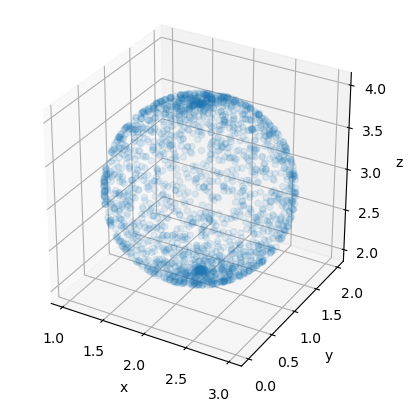

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

xs = photons[:, 0] + photons[:, 3]
ys = photons[:, 1] + photons[:, 4]
zs = photons[:, 2] + photons[:, 5]
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))

ax.scatter(xs, ys, zs, alpha=0.1)

In [42]:
def check_hits_vectorized_per_track_np(
    photons, sensor_radius, points
):
    t0 = time.perf_counter()

    ray_origin = photons[:, :3]
    ray_direction = photons[:, 3:]

    # Calculate vectors from ray origin to all points
    vectors_to_points = points - ray_origin[:, None, :]

    # Project all vectors onto the ray direction using einsum
    dot_products_numerator = np.einsum(
        "ijk,ik->ij", vectors_to_points, ray_direction
    )
    dot_products_denominator = np.sum(
        ray_direction * ray_direction, axis=-1
    )

    # Calculate t_values
    t_values = dot_products_numerator / dot_products_denominator[:, None]

    # Calculate the points on the ray closest to the given points
    closest_points_on_ray = (
        ray_origin[:, None, :]
        + t_values[:, :, None] * ray_direction[:, None, :]
    )

    # Calculate the Euclidean distances between all points and their closest points on the ray
    distances = np.linalg.norm(points - closest_points_on_ray, axis=2)

    # Apply the mask
    mask = t_values < 0
    distances = np.where(mask, 999.0, distances)

    # Find the indices of the minimum distances
    indices = np.argmin(distances, axis=1)

    # Get the good indices based on sensor_radius
    good_indices = indices[
        distances[np.arange(indices.shape[0]), indices] < sensor_radius
    ]
    t1 = time.perf_counter()

    print(f'vectorization np process time: {t1 - t0}')

    return good_indices

In [43]:
photons = gen_photons(5000)
good_indices = check_hits_vectorized_per_track_np(
    photons,
    cyl_sensor_radius,
    np.array(detector.all_points),
)

vectorization np process time: 0.4201642512343824


In [55]:
# one event is one track!! (logic is set up accordingly)

# define all fields for h5 output file.
trk_origins = []  # the track origin.    This is a list of lists for every event.
trk_dirs = []  # the track direction. This is a list of lists for every event.
trk_lengths = []  # the track length.    This is a list of lists for every event.
# at some point the length will be replaced by something proper (e.g. E, and then we store also PDG)
# ... (but lets use this length for the moment).
displays = []

# -- the dataset generation:
stime = time.perf_counter()
ID_to_PE = np.zeros(len(detector.all_points))

track_origin = None
track_direction = None
L = None

if SIM_MODE == 1:
    # let's chose the vertex uniformely in a 2x2x2 box around the [0,0,0].
    track_origin = np.array([-1 + 2 * np.random.uniform() for _ in range(3)])

    # let's chose the track direction randomly.
    track_direction = normalize(generate_isotropic_random_vector())

    # track length, chosen such that the track is always contained in the detector.
    L = 2.5

trk_dirs.append(track_direction)
trk_origins.append(track_origin)
trk_lengths.append(L)

Nphot = None
if SIM_MODE == 0:
    Nphot = Np
elif SIM_MODE == 1:
    # let's make that every cherenkov track has 1000 photons.
    Nphot = int(400 * L)

ray_vectors = None
if SIM_MODE == 1:
    ray_vectors = generate_vectors_on_cone_surface(
        track_direction, np.radians(40), Nphot
    )

ray_origins = []
ray_dirs = []

evt_ray_origins = []
evt_ray_dirs = []

photons = gen_photons(Nphot)
good_indices = check_hits_vectorized_per_track(
    photons,
    cyl_sensor_radius,
    np.array(detector.all_points, dtype=np.float32),
)
idx, cts = np.unique(good_indices, return_counts=True)
ID_to_PE[idx] = cts

ray_origins.append(photons[:, :3])
ray_dirs.append(photons[:, 3:])

displays.append(ID_to_PE)

evts = {
    "trk_origins": trk_origins,
    "trk_dirs": trk_dirs,
    "trk_lengths": trk_lengths,
    "ray_origins": ray_origins,
    "ray_dirs": ray_dirs,
    "PE": displays,
}

evts_df = pd.DataFrame(evts)
# evts_df.to_hdf('datasets/dataset_'+str(ds_id)+'_events.h5',key='data')
# -----------------------------

# store geom information
geom = {
    "positions": list(detector.all_points),
    "case": list(detector.ID_to_case.values()),
}

geom_df = pd.DataFrame(geom)
# geom_df.to_hdf('datasets/dataset_0_geom.h5',key='data')
# -----------------------------

print("Torch exec. time: ", f"{time.perf_counter()-stime:.2f} s.")

vectorization process time: 0.08779521519318223
Torch exec. time:  0.12 s.


### Perform the simulation

In [40]:
# simulation mode ---- 0: isotropic; 1: cherenkov.
SIM_MODE = 0
Ndatasets = 1
Np = 5000

In [62]:
# one event is one track!! (logic is set up accordingly)

# define all fields for h5 output file.
trk_origins = []  # the track origin.    This is a list of lists for every event.
trk_dirs = []  # the track direction. This is a list of lists for every event.
trk_lengths = []  # the track length.    This is a list of lists for every event.
# at some point the length will be replaced by something proper (e.g. E, and then we store also PDG)
# ... (but lets use this length for the moment).

ray_origins = []
ray_dirs = []
displays = []

# -- the dataset generation:
stime = time.perf_counter()
ID_to_PE = np.zeros(len(detector.all_points))

track_origin = None
track_direction = None
L = None

if SIM_MODE == 1:
    # let's chose the vertex uniformely in a 2x2x2 box around the [0,0,0].
    track_origin = np.array([-1 + 2 * np.random.uniform() for _ in range(3)])

    # let's chose the track direction randomly.
    track_direction = normalize(generate_isotropic_random_vector())

    # track length, chosen such that the track is always contained in the detector.
    L = 2.5

trk_dirs.append(track_direction)
trk_origins.append(track_origin)
trk_lengths.append(L)

Nphot = None
if SIM_MODE == 0:
    Nphot = Np
elif SIM_MODE == 1:
    # let's make that every cherenkov track has 1000 photons.
    Nphot = int(400 * L)

ray_vectors = None
if SIM_MODE == 1:
    ray_vectors = generate_vectors_on_cone_surface(
        track_direction, np.radians(40), Nphot
    )

evt_ray_origins = []
evt_ray_dirs = []

vects = []
origs = []
for n in range(Nphot):
    ray_direction = None
    ray_origin = None
    if SIM_MODE == 0:
        ray_direction = normalize(generate_isotropic_random_vector())
        ray_origin = [0, 0, 0]
    elif SIM_MODE == 1:
        ray_direction = normalize(
            [
                ray_vectors[:, 0][n],
                ray_vectors[:, 1][n],
                ray_vectors[:, 2][n],
            ]
        )
        ray_origin = (
            track_origin + (L * np.random.uniform()) * track_direction
        )  # we assume dNphot/ds is constant...
    vects.append(ray_direction)
    origs.append(ray_origin)

photons = gen_photons(Nphot)

good_indices = check_hits_vectorized_per_track(
    # np.hstack([origs, vects]),
    photons,
    cyl_sensor_radius,
    np.array(detector.all_points, dtype=np.float32),
)
idx, cts = np.unique(good_indices, return_counts=True)
ID_to_PE[idx] = cts

ray_origins.append(origs)
ray_dirs.append(vects)

displays.append(ID_to_PE)

evts = {
    "trk_origins": trk_origins,
    "trk_dirs": trk_dirs,
    "trk_lengths": trk_lengths,
    "ray_origins": ray_origins,
    "ray_dirs": ray_dirs,
    "PE": displays,
}

evts_df = pd.DataFrame(evts)
# evts_df.to_hdf('datasets/dataset_'+str(ds_id)+'_events.h5',key='data')
# -----------------------------

# store geom information
geom = {
    "positions": list(detector.all_points),
    "case": list(detector.ID_to_case.values()),
}

geom_df = pd.DataFrame(geom)
# geom_df.to_hdf('datasets/dataset_0_geom.h5',key='data')
# -----------------------------

print("Torch exec. time: ", f"{time.perf_counter()-stime:.2f} s.")

vectorization process time: 0.06670549418777227
Torch exec. time:  0.19 s.


### Visualization

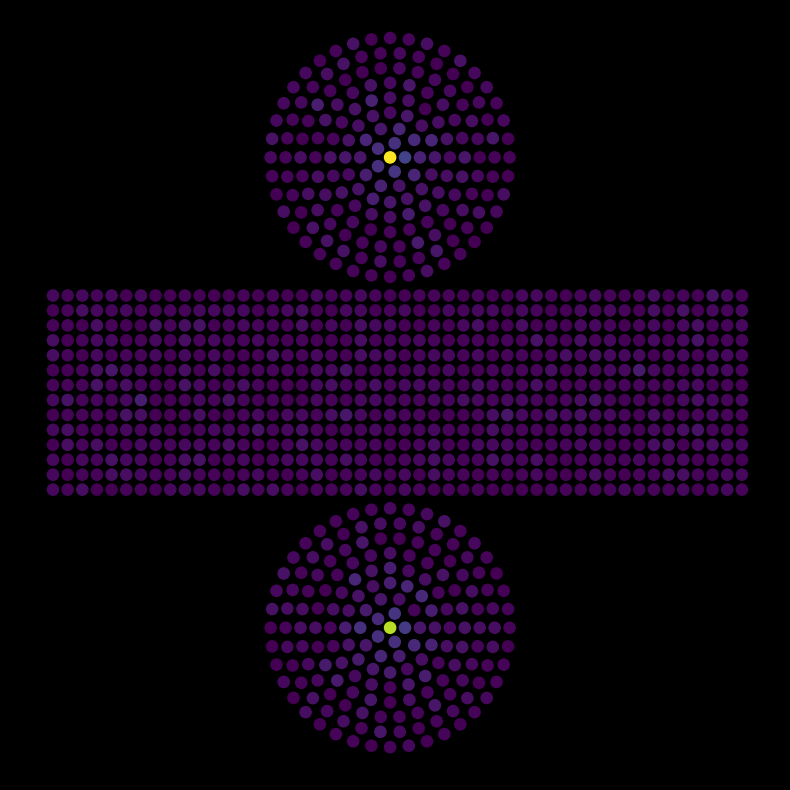

In [63]:
evt_ID = 0

ID_to_position = {i: x for i, x in enumerate(geom_df.positions)}
ID_to_case = {i: x for i, x in enumerate(geom_df.case)}
ID_to_PE = {i: x for i, x in enumerate(evts_df.iloc[evt_ID].PE)}

show_2D_display(
    ID_to_position, ID_to_PE, ID_to_case, cyl_sensor_radius, cyl_radius, cyl_height
)  # , file_name='evt_example.pdf')

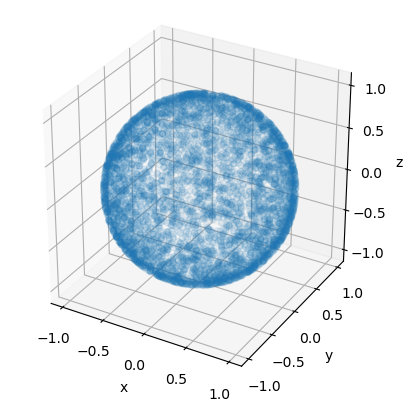

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

origs = np.array(origs)
vects = np.array(vects)

xs = origs[:, 0] + vects[:, 0]
ys = origs[:, 1] + vects[:, 1]
zs = origs[:, 2] + vects[:, 2]
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))

ax.scatter(xs, ys, zs, alpha=0.1)

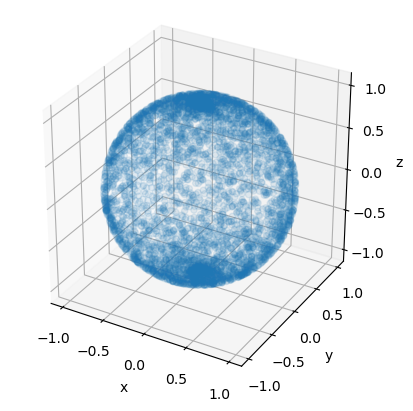

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

xs = photons[:, 0] + photons[:, 3]
ys = photons[:, 1] + photons[:, 4]
zs = photons[:, 2] + photons[:, 5]
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))

ax.scatter(xs, ys, zs, alpha=0.1)

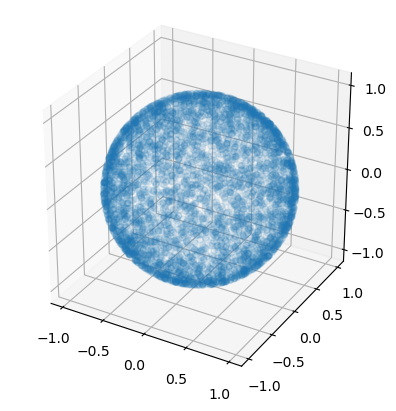

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter, imshow
from mpl_toolkits.mplot3d import Axes3D

N = 5000

z = np.random.uniform(-1, 1, N)
phi = np.random.uniform(-np.pi, np.pi, N)
rxy = np.sqrt(1 - z**2)

x = rxy * np.cos(phi)
y = rxy * np.sin(phi)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.scatter(x, y, z, alpha=0.1)
plt.show()